# Домашнее задание 
# Математика — Домашнее задание 6
# А.&#8201;Д. Егоров<h1/>

In [1114]:
import numpy as np
import scipy as sp 

import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns

from collections import Counter

import datetime
from dateutil.parser import parse

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
%matplotlib inline

## Задание 1

Данные взяты отсюда: https://www.kaggle.com/datasets/kallefischer/app-user-dataset

In [645]:
df_users = pd.read_csv("./user_demographics.csv")
df_users["uid"] = df_users["uid"].agg(func=lambda x: int(x))
df_users

,uid,reg_date,device,gender,country,age
0,54030035,2017-06-29T00:00:00Z,and,M,USA,19
1,72574201,2018-03-05T00:00:00Z,iOS,F,TUR,22
2,64187558,2016-02-07T00:00:00Z,iOS,M,USA,16
3,92513925,2017-05-25T00:00:00Z,and,M,BRA,41
4,99231338,2017-03-26T00:00:00Z,iOS,M,FRA,59
...,...,...,...,...,...,...
9995,43138741,2016-11-23T00:00:00Z,and,M,BRA,16
9996,30326568,2016-08-21T00:00:00Z,and,M,BRA,15
9997,92384369,2015-08-20T00:00:00Z,and,F,DEU,33
9998,98809962,2017-04-08T00:00:00Z,iOS,F,FRA,32


Сгенерируем фейковые данные о времени, проведенном пользователем в сервисе. 

In [646]:
# Изначально сделаем так, что чем меньше возраст, тем больше времени он проводит в сервисе
df_users["time_spent"] = df_users["age"].values.max() - (df_users["age"] - df_users["age"].values.mean())
df_users["time_spent"] = df_users["time_spent"].agg(func=lambda x: x * abs(np.random.normal(2, 1.2)))

# Поправка на время взаимодействи в зависимости от страны
mult = dict(zip(df_users["country"].unique(), [1.3, 0.9, 1., 1.2, 1.03, 1.05]))
df_users["time_spent"] = df_users["time_spent"] * df_users["country"].apply(func=lambda x: mult[x])

# Поправка на время взаимодействия с сервисом в зависимости от пола
mult = dict(zip(["M", "F"], [1.2, 1.]))
df_users["time_spent"] = df_users["time_spent"] * df_users["gender"].apply(func=lambda x: mult[x])

df_users

,uid,reg_date,device,gender,country,age,time_spent
0,54030035,2017-06-29T00:00:00Z,and,M,USA,19,442.655886
1,72574201,2018-03-05T00:00:00Z,iOS,F,TUR,22,106.983765
2,64187558,2016-02-07T00:00:00Z,iOS,M,USA,16,277.982611
3,92513925,2017-05-25T00:00:00Z,and,M,BRA,41,168.480363
4,99231338,2017-03-26T00:00:00Z,iOS,M,FRA,59,48.410089
...,...,...,...,...,...,...,...
9995,43138741,2016-11-23T00:00:00Z,and,M,BRA,16,183.287422
9996,30326568,2016-08-21T00:00:00Z,and,M,BRA,15,321.413165
9997,92384369,2015-08-20T00:00:00Z,and,F,DEU,33,196.356720
9998,98809962,2017-04-08T00:00:00Z,iOS,F,FRA,32,249.898445


Посмотрим на распределение возраста пользователей

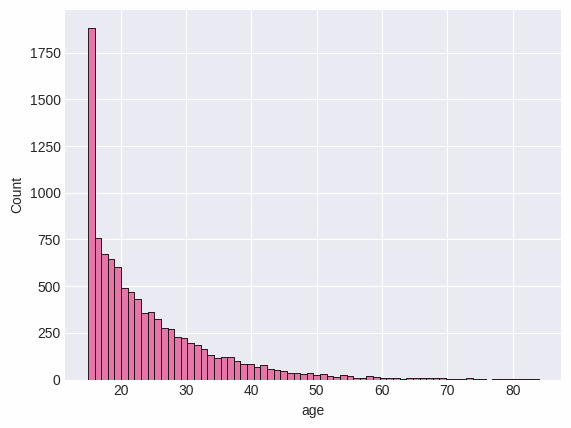

In [762]:
sns.histplot(df_users["age"])
sns.histplot(df_users["age"])
plt.show()

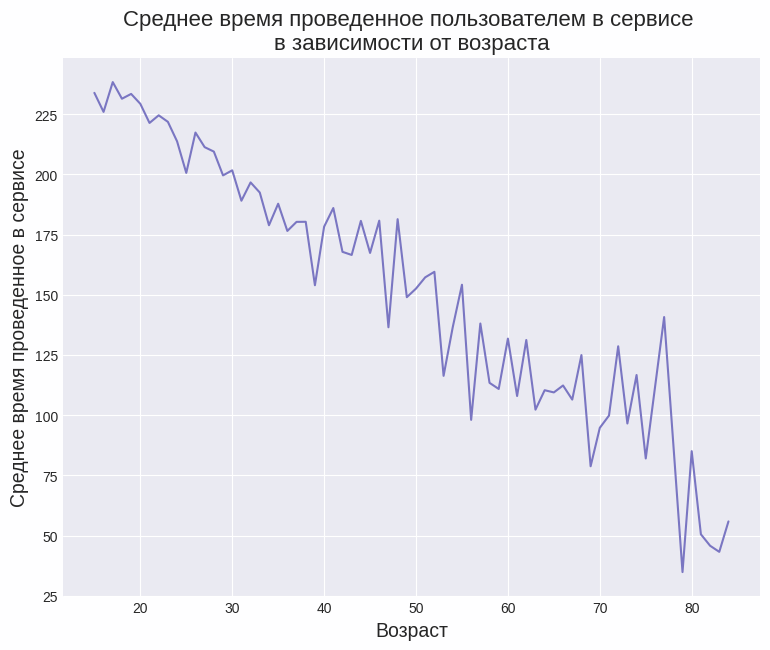

In [760]:
plt.figure(figsize=(9,7))
plt.plot(
    sorted(df_users["age"].unique()),
    df_users.groupby(by="age").agg({"time_spent": "mean"})
)
plt.title("Cреднее время проведенное пользователем в сервисе \nв зависимости от возраста", fontsize=16)
plt.xlabel("Возраст", fontsize=14)
plt.ylabel("Среднее время проведенное в сервисе", fontsize=14)
plt.show()

Посмотрим, какие страны присутствуют в выборке:

In [ ]:
df_users["country"].unique()

array(['USA', 'TUR', 'BRA', 'FRA', 'DEU', 'CAN'], dtype=object)

Количество пользователей из разных стран:

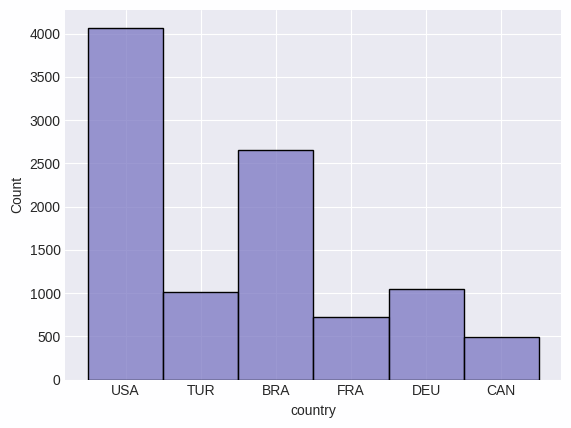

In [761]:
sns.histplot(df_users["country"])
plt.show()

## Задание 2

Исходя из того, что пользователей можно разделить по: 
* странам, 
* полу,
* возрасту,
* операционной системе,

будем придумывать гипотезы и проверять их.

### Тест Стьюдента

Тест Стьюдента пододит для проверки равенства средних, тогда проверим с его помощью следующие гипотезы: 

$$H_0 = \{\text{Среднее значение возраста пользователей для страны A и страны B равны} \}$$

In [891]:
# соберем данные о возрасте пользователей в удобном нам виде
# для дальшейшей агрегации
ages = dict()
for country in df_users["country"].unique():
    ages[country] = np.array(df_users[df_users["country"] == country]["age"])

In [892]:
ttest_ages_data = []
tmp_countries = list(df_users["country"].unique())
for country_i in tmp_countries:
    for country_j in tmp_countries:
        if country_i != country_j:
            # Проводим тест Стьюдента
            test = sp.stats.ttest_ind(ages[country_i], ages[country_j])
            ttest_ages_data.append([country_i, country_j, test.statistic, test.pvalue])
    tmp_countries.remove(country_i)
df_ttest_ages = pd.DataFrame(
    ttest_ages_data, columns=["A", "B", "ttest_statistic", "ttest_pvalue"]
)
df_ttest_ages

,A,B,ttest_statistic,ttest_pvalue
0,USA,TUR,1.310264,0.190166
1,USA,BRA,1.191207,0.233614
2,USA,FRA,0.148787,0.881728
3,USA,DEU,0.918055,0.358633
4,USA,CAN,0.529540,0.596457
5,BRA,TUR,0.467491,0.640176
6,BRA,FRA,-0.586227,0.557762
7,BRA,DEU,0.073290,0.941579
8,BRA,CAN,-0.085409,0.931942
9,DEU,TUR,0.328477,0.742585


Из таблицы видно, что pvalue для всех стран больше 0.05, следовательно, по критерию Стьюдента гипотезу о равестве среднего возраста для всех стран принимаем.

### Еще тест Стьюдента
Также тестом Стьюдента проверим гипотезу
$$
H_0 = \{\text{Среднее время пользователей для Германии и Канады равны} \}.
$$

In [793]:
DEU_users_time = df_users[(df_users["country"] == "DEU")]["time_spent"]
CAN_users_time = df_users[(df_users["country"] == "CAN")]["time_spent"]

test = sp.stats.ttest_ind(DEU_users_time, CAN_users_time)
pd.DataFrame([["DEU vs CAN", test.statistic, test.pvalue]], columns=["countries", "ttest_statistic", "ttest_pvalue"])

,countries,ttest_statistic,ttest_pvalue
0,DEU vs CAN,-0.796529,0.425848


По тесту Стьюдента данная гипотеза подтверждается. 

Если же мы будем сравнивать время пользователей для Бразилии и Турции, т.е. проверять гипотезу
$$
H_0 = \{\text{Среднее время пользователей для Бразилии и Турции равны} \}.
$$

In [792]:
BRA_users_time = df_users[(df_users["country"] == "BRA")]["time_spent"]
TUR_users_time = df_users[(df_users["country"] == "TUR")]["time_spent"]

test = sp.stats.ttest_ind(BRA_users_time, TUR_users_time)
pd.DataFrame([["BRA vs TUR", test.statistic, test.pvalue]], columns=["countries", "ttest_statistic", "ttest_pvalue"])

,countries,ttest_statistic,ttest_pvalue
0,BRA vs TUR,5.29705,1.246172e-07


Получим, что $pvalue < 0.05$, следовательно, данную гипотезу отклоняем.

Проведем аналогичное сравнение для всех стран:

In [1019]:
ttest_time_data = []
tmp_countries = list(df_users["country"].unique())
for country_i in tmp_countries:
    for country_j in tmp_countries:
        if country_i != country_j:
            # Проводим тест Стьюдента
            test = sp.stats.ttest_ind(
                df_users[(df_users["country"] == country_i)]["time_spent"],
                df_users[(df_users["country"] == country_j)]["time_spent"],
                #equal_var=False,
            )
            ttest_time_data.append([country_i, country_j, test.statistic, round(test.pvalue, 5)])
    tmp_countries.remove(country_i)
df_ttest_time = pd.DataFrame(
    ttest_time_data, columns=["A", "B", "ttest_statistic", "ttest_pvalue"]
)
df_ttest_time

,A,B,ttest_statistic,ttest_pvalue
0,USA,TUR,15.399371,0.00000
1,USA,BRA,15.935410,0.00000
2,USA,FRA,2.805923,0.00504
3,USA,DEU,10.275009,0.00000
4,USA,CAN,6.635798,0.00000
5,BRA,TUR,5.297050,0.00000
6,BRA,FRA,-7.444999,0.00000
7,BRA,DEU,-0.744135,0.45684
8,BRA,CAN,-1.472141,0.14108
9,DEU,TUR,5.089259,0.00000


Можно сделать вывод, что время просмотра зависит от страны.

### Тест Манна-Уитни

Тест Манна-Уитни сравнивает выборки на одинаковость распределений.


Проверим правда ли, что распределения времени проведенного в сервисе для людьми старше 30 лет в США и в Турции одинаково. 
<!-- , и распределения выборок одинаковы с точностью до смещения: -->
<!-- , т.&#8201;е.  -->
<!-- $$
    H_0 = \{ {\text{Время проведенное в сервисе для людей старше 30 лет в США больше, чем в Турции}} \} 
$$ -->

In [695]:
USA_users_time = df_users[(df_users["country"] == "USA") & (df_users["age"] >= 30)]["time_spent"]
TUR_users_time = df_users[(df_users["country"] == "TUR") & (df_users["age"] >= 30)]["time_spent"]

test = sp.stats.mannwhitneyu(USA_users_time, TUR_users_time, alternative="greater")
pd.DataFrame([["USA vs TUR", test.statistic, test.pvalue]], columns=["countries", "MW_statistic", "MW_pvalue"])

,countries,MW_statistic,MW_pvalue
0,USA vs TUR,122287.0,1.943962e-08


Полученное $pvalue < 0.05$, следовательно, распределения не одинаковы. 

Посмотрим может для Турции существует смещение, при котором, тест выполнится: 
для начала постоим KDEplot:

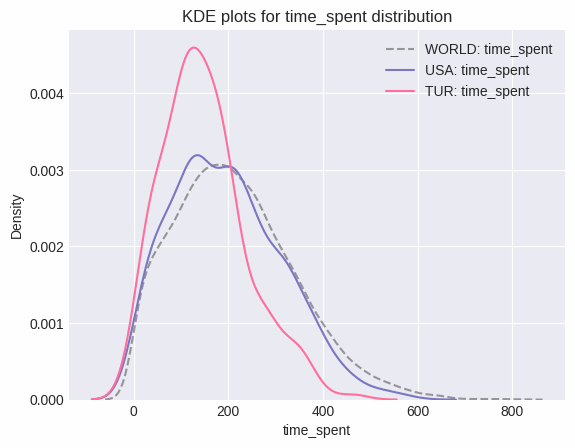

In [696]:
sns.kdeplot(df_users["time_spent"], label="WORLD: time_spent", ls="dashed", c="gray", alpha=0.8)
sns.kdeplot(USA_users_time, label="USA: time_spent")
sns.kdeplot(TUR_users_time, label="TUR: time_spent")
plt.title("KDE plots for time_spent distribution")
plt.legend()
plt.show()

Действительно, для Турции существует смещение в левую сторону:

In [699]:
np.percentile(USA_users_time, q=50) - np.percentile(TUR_users_time, q=50)

51.549633235038726

и при должном смещении тест Манна-Уитни выполняется (pvalue > 0.05):

In [700]:
sp.stats.mannwhitneyu(USA_users_time - 51.549633235038726, TUR_users_time, alternative="greater")

MannwhitneyuResult(statistic=94150.0, pvalue=0.8456737353751296)

### Еще тест Манна-Уитни
Проверим правда ли, что распределение времени проведенного в сервисе у мужчин больше, чем у жещин совпадает с точностью до смещения: 
<!-- , т.&#8201;е. 
$$
    H_0 = \{ {\text{Мужчины проводят времени в сервисе больше, чем женщины}} \} 
$$ -->

In [702]:
Male_users_time = df_users[(df_users["gender"] == "M")]["time_spent"]
Female_users_time = df_users[(df_users["gender"] == "F")]["time_spent"]

test = sp.stats.mannwhitneyu(Male_users_time, Female_users_time, alternative="greater")
pd.DataFrame([["M vs F", test.statistic, test.pvalue]], columns=["gender", "MW_statistic", "MW_pvalue"])

,gender,MW_statistic,MW_pvalue
0,M vs F,14374837.0,1.001494e-39


Аналогично предыдущему случаю постоим KDEplot и попробуем сместить одну из выборок:

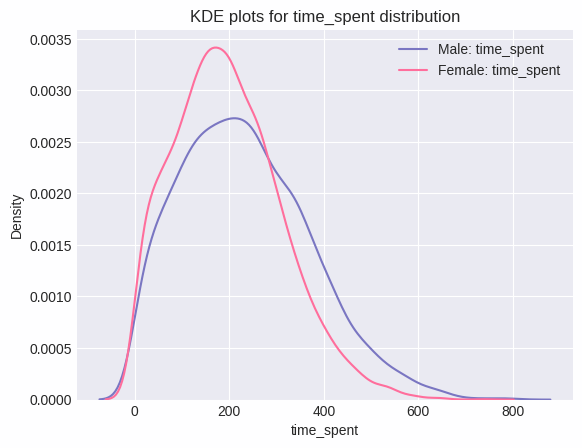

In [703]:
sns.kdeplot(Male_users_time, label="Male: time_spent")
sns.kdeplot(Female_users_time, label="Female: time_spent")
plt.title("KDE plots for time_spent distribution")
plt.legend()
plt.show()

In [704]:
np.percentile(Male_users_time, q=50) - np.percentile(Female_users_time, q=50)

33.99934408785373

In [705]:
sp.stats.mannwhitneyu(Male_users_time - 33.99934408785373, Female_users_time, alternative="greater")

MannwhitneyuResult(statistic=12464325.0, pvalue=0.5432736725282384)

Данная гипотеза подтверждается: при должном смещении тест Манна-Уитни выполняется.
Также можно сделать вывод, что мужчины проводят в сервисе больше времени, чем женщины.

## Тест Фишера



### ________
### Пометка к тесту Фишера
Я не понял что именно подразумевается под тестом Фишера:
F-test или Fisher's exact test.
Потому сдел оба варианта. Всеже, предполагаю, что имелся в виду ANOVA из лекции, он же `f_oneway`. 
Так что Fisher's exact test приведен как часть задания 5.

### ________

### F-test (`f_oneway()` )

### Сравним с помощью ANOVA возраст в разных странах:

1) $$H_0 = \{ \text{Средний возраст пользователя в Бразилии и Германии одинаковый} \}$$

In [719]:
# Воспользуемся словарем ages составленным ранее
f_test = sp.stats.f_oneway(ages["BRA"], ages["DEU"])
pd.DataFrame([["BRA & DEU", f_test.statistic, f_test.pvalue]], columns=["countries", "ANOVA_statistic", "ANOVA_pvalue"])

,countries,ANOVA_statistic,ANOVA_pvalue
0,BRA & DEU,0.005371,0.941579


$pvalue > 0.05$, следовательно, гипотеза принимается.

2) Воспользуемся возможностями ANOVA и сравним более чем две страны: 
$$H_0 = \{ \text{Средний возраст пользователя во Франции, Канаде и Германии одинаковый} \}$$

In [717]:
# Воспользуемся словарем ages составленным ранее
f_test = sp.stats.f_oneway(ages["FRA"], ages["CAN"], ages["DEU"])
pd.DataFrame([["FRA & CAN & TUR", f_test.statistic, f_test.pvalue]], columns=["countries", "ANOVA_statistic", "ANOVA_pvalue"])

,countries,ANOVA_statistic,ANOVA_pvalue
0,FRA & CAN & TUR,0.158672,0.853285


$pvalue > 0.05$, следовательно, гипотеза принимается.

3) 
$$H_0 = \{ \text{Средний возраст пользователя во Франции, Бразилии, США, Турции, Канаде и Германии одинаковый} \}$$

In [720]:
# Воспользуемся словарем ages составленным ранее
f_test = sp.stats.f_oneway(ages["FRA"], ages["BRA"], ages["USA"], ages["TUR"], ages["CAN"], ages["DEU"])
pd.DataFrame([["ALL", f_test.statistic, f_test.pvalue]], columns=["countries", "ANOVA_statistic", "ANOVA_pvalue"])

,countries,ANOVA_statistic,ANOVA_pvalue
0,ALL,0.581357,0.714352


$pvalue > 0.05$, следовательно, гипотеза принимается.

### Сравним с помощью ANOVA время проведенное в сервисе людьми в разных странах:

1) $$H_0 = \{ \text{Время проведенное людьми в США и Турции одинаковое} \}$$

In [726]:
# Воспользуемся словарем ages составленным ранее
USA_users_time = df_users[(df_users["country"] == "USA")]["time_spent"]
TUR_users_time = df_users[(df_users["country"] == "TUR")]["time_spent"]

f_test = sp.stats.f_oneway(USA_users_time, TUR_users_time)
pd.DataFrame([["USA & TUR", f_test.statistic, f_test.pvalue]], columns=["countries", "ANOVA_statistic", "ANOVA_pvalue"])

,countries,ANOVA_statistic,ANOVA_pvalue
0,USA & TUR,237.140629,2.472716e-52


$pvalue < 0.05$, следовательно, гипотеза отклоняется.

2) $$H_0 = \{ \text{Время проведенное людьми в сервисе в Канаде, Бразилии и Германии одинаковое} \}$$

In [725]:
# Воспользуемся словарем ages составленным ранее
CAN_users_time = df_users[df_users["country"] == "CAN"]["time_spent"]
BRA_users_time = df_users[df_users["country"] == "BRA"]["time_spent"]
DEU_users_time = df_users[df_users["country"] == "DEU"]["time_spent"]

f_test = sp.stats.f_oneway(CAN_users_time, BRA_users_time, DEU_users_time)
pd.DataFrame([["CAN & BRA & DEU", f_test.statistic, f_test.pvalue]], columns=["countries", "ANOVA_statistic", "ANOVA_pvalue"])

,countries,ANOVA_statistic,ANOVA_pvalue
0,CAN & BRA & DEU,1.16269,0.312745


$pvalue > 0.05$, следовательно, гипотеза принимается.

3) "Испортим выборку", подмешаем заведомо отличающееся значение:
$$H_0 = \{ \text{Время проведенное людьми в сервисе в США, Канаде, Бразилии и Германии одинаковое} \}$$

In [764]:
USA_users_time = df_users[df_users["country"] == "USA"]["time_spent"]
CAN_users_time = df_users[df_users["country"] == "CAN"]["time_spent"]
BRA_users_time = df_users[df_users["country"] == "BRA"]["time_spent"]
DEU_users_time = df_users[df_users["country"] == "DEU"]["time_spent"]

f_test = sp.stats.f_oneway(USA_users_time, CAN_users_time, BRA_users_time, DEU_users_time)
pd.DataFrame([["CAN & BRA & DEU", f_test.statistic, f_test.pvalue]], columns=["countries", "ANOVA_statistic", "ANOVA_pvalue"])

,countries,ANOVA_statistic,ANOVA_pvalue
0,CAN & BRA & DEU,107.552605,2.627637e-68


$pvalue < 0.05$, следовательно, гипотеза отклоняется, какая-то выборка дает отличный от других результат.

## Задание 3
### Попарное сравнение через тесты Стьюдента и Фишера

Возьмем таблицу теста Стьюдента, составленную ранее для гипотез типа: {Среднее значение возраста пользователей для страны A и страны B равны}:

In [773]:
df_ttest_ages

,A,B,ttest_statistic,ttest_pvalue
0,USA,TUR,1.310264,0.190166
1,USA,BRA,1.191207,0.233614
2,USA,FRA,0.148787,0.881728
3,USA,DEU,0.918055,0.358633
4,USA,CAN,0.529540,0.596457
5,BRA,TUR,0.467491,0.640176
6,BRA,FRA,-0.586227,0.557762
7,BRA,DEU,0.073290,0.941579
8,BRA,CAN,-0.085409,0.931942
9,DEU,TUR,0.328477,0.742585


Создадим датафрейм с попарными сравнениями возрастов разных стран через тест Фишера

In [784]:
ftest_ages_data = []
tmp_countries = list(df_users["country"].unique())
for country_i in tmp_countries:
    for country_j in tmp_countries:
        if country_i != country_j:
            # Проводим тест Стьюдента
            test = sp.stats.f_oneway(
                df_users[(df_users["country"] == country_i)]["age"],
                df_users[(df_users["country"] == country_j)]["age"],
            )
            ftest_ages_data.append([country_i, country_j, test.statistic, test.pvalue])
    tmp_countries.remove(country_i)
df_ftest_ages = pd.DataFrame(
    ftest_ages_data, columns=["A", "B", "f_test_statistic", "f_test_pvalue"]
)
df_ftest_ages

,A,B,f_test_statistic,f_test_pvalue
0,USA,TUR,1.716792,0.190166
1,USA,BRA,1.418975,0.233614
2,USA,FRA,0.022138,0.881728
3,USA,DEU,0.842826,0.358633
4,USA,CAN,0.280413,0.596457
5,BRA,TUR,0.218548,0.640176
6,BRA,FRA,0.343662,0.557762
7,BRA,DEU,0.005371,0.941579
8,BRA,CAN,0.007295,0.931942
9,DEU,TUR,0.107897,0.742585


Смерджим датафреймы и посмотрим на результат:

In [795]:
pd.merge(left=df_ttest_ages, right=df_ftest_ages).drop(
    columns=["ttest_statistic", "f_test_statistic"]
)

,A,B,ttest_pvalue,f_test_pvalue
0,USA,TUR,0.190166,0.190166
1,USA,BRA,0.233614,0.233614
2,USA,FRA,0.881728,0.881728
3,USA,DEU,0.358633,0.358633
4,USA,CAN,0.596457,0.596457
5,BRA,TUR,0.640176,0.640176
6,BRA,FRA,0.557762,0.557762
7,BRA,DEU,0.941579,0.941579
8,BRA,CAN,0.931942,0.931942
9,DEU,TUR,0.742585,0.742585


Как видно из полученной таблицы, значения $pvalue$ для попарных сравнений тестом стьюдента и тестом Фишера совпадают, как это и должно быть.

Аналогично сравним гипотезы типа: {Среднее время пользователей проведенное в сервисе для стран A и B равны}:

Использует таблицу составленную ранее:

In [797]:
df_ttest_time

,A,B,ttest_statistic,ttest_pvalue
0,USA,TUR,15.399371,0.00000
1,USA,BRA,15.935410,0.00000
2,USA,FRA,2.805923,0.00504
3,USA,DEU,10.275009,0.00000
4,USA,CAN,6.635798,0.00000
5,BRA,TUR,5.297050,0.00000
6,BRA,FRA,-7.444999,0.00000
7,BRA,DEU,-0.744135,0.45684
8,BRA,CAN,-1.472141,0.14108
9,DEU,TUR,5.089259,0.00000


Проведем тест Фишера:

In [799]:
ftest_time_data = []
tmp_countries = list(df_users["country"].unique())
for country_i in tmp_countries:
    for country_j in tmp_countries:
        if country_i != country_j:
            # Проводим тест Стьюдента
            test = sp.stats.f_oneway(
                df_users[(df_users["country"] == country_i)]["time_spent"],
                df_users[(df_users["country"] == country_j)]["time_spent"],
            )
            ftest_time_data.append([country_i, country_j, test.statistic, round(test.pvalue, 5)])
    tmp_countries.remove(country_i)
df_ftest_time = pd.DataFrame(
    ftest_time_data, columns=["A", "B", "f_test_statistic", "f_test_pvalue"]
)
df_ftest_time

,A,B,f_test_statistic,f_test_pvalue
0,USA,TUR,237.140629,0.00000
1,USA,BRA,253.937297,0.00000
2,USA,FRA,7.873203,0.00504
3,USA,DEU,105.575815,0.00000
4,USA,CAN,44.033817,0.00000
5,BRA,TUR,28.058741,0.00000
6,BRA,FRA,55.428004,0.00000
7,BRA,DEU,0.553736,0.45684
8,BRA,CAN,2.167199,0.14108
9,DEU,TUR,25.900554,0.00000


Смерджим датафреймы и посмотрим на результат:

In [800]:
pd.merge(left=df_ttest_time, right=df_ftest_time).drop(
    columns=["ttest_statistic", "f_test_statistic"]
)

,A,B,ttest_pvalue,f_test_pvalue
0,USA,TUR,0.00000,0.00000
1,USA,BRA,0.00000,0.00000
2,USA,FRA,0.00504,0.00504
3,USA,DEU,0.00000,0.00000
4,USA,CAN,0.00000,0.00000
5,BRA,TUR,0.00000,0.00000
6,BRA,FRA,0.00000,0.00000
7,BRA,DEU,0.45684,0.45684
8,BRA,CAN,0.14108,0.14108
9,DEU,TUR,0.00000,0.00000


Для данных гипотез тесты Стьюдента и Фишера для попарных сравнений так же совпадают.

## Задание 4
Постройте точный и эфронов доверительные интервал для выбранных метрик. Проверьте соответствуют ли эти доверительные интервалы результатам теста Стьюдента.

In [1073]:
def t_conf_int(alpha, X):
    """
    Точный доверительный интервал
    """

    mu_hat = np.mean(X)
    var_hat = np.var(X)
    n = len(X)

    t_rv = sp.stats.t(df=n - 1)
    t_crit = t_rv.ppf(1 - alpha / 2)

    left = mu_hat - t_crit * np.sqrt(var_hat / n)
    right = mu_hat + t_crit * np.sqrt(var_hat / n)

    return left, right

### Доверительные интервалы для среднего возраста в стране

Точный доверитаельный интервал:

In [1283]:
CI_type = "Точный"
CI_for = "avg_user_age"
CI_ages_data = []
tmp_countries = list(df_users["country"].unique())
for country_i in tmp_countries:
    for country_j in tmp_countries:
        if country_i != country_j:
            X = df_users[df_users["country"] == country_i]["age"].to_list()
            Y = df_users[df_users["country"] == country_j]["age"].to_list()
            CI_ages_data.append(
                [
                    country_i,
                    country_j,
                    CI_type,
                    CI_for,
                    np.mean(X),
                    np.mean(Y),
                    [round(x, 4) for x in t_conf_int(0.05, X)],
                    [round(x, 4) for x in t_conf_int(0.05, Y)],
                ]
            )
    tmp_countries.remove(country_i)

df_CI_age_tt = pd.DataFrame(
    CI_ages_data, columns=["A", "B", "CI_type", "CI_for", "mean(A)", "mean(B)", "CI_values_t(A)", "CI_values_t(B)"]
)
# df_CI_age_tt

Эфронов доверительный интервал:

In [1284]:
CI_type = "Эфронов"
CI_ages_data = []
tmp_countries = list(df_users["country"].unique())
for country_i in tmp_countries:
    for country_j in tmp_countries:
        if country_i != country_j:
            X_mean = []
            Y_mean = []
            X = df_users[df_users["country"] == country_i]["age"]
            Y = df_users[df_users["country"] == country_j]["age"]
            for _ in range(len(X)):
                X_mean.append(np.mean(np.random.choice(X, size=len(X), replace=True)))
            for _ in range(len(Y)):
                Y_mean.append(np.mean(np.random.choice(Y, size=len(Y), replace=True)))
            CI_ages_data.append(
                [
                    country_i,
                    country_j,
                    CI_type,
                    CI_for,
                    np.mean(X),
                    np.mean(Y),
                    [round(x, 4) for x in np.percentile(X_mean, q=[2.5, 97.5])],
                    [round(x, 4) for x in np.percentile(Y_mean, q=[2.5, 97.5])],
                ]
            )
    tmp_countries.remove(country_i)


df_CI_age_BB = pd.DataFrame(
    CI_ages_data,
    columns=[
        "A",
        "B",
        "CI_type",
        "CI_for",
        "mean(A)",
        "mean(B)",
        "CI_values_bootstrap(A)",
        "CI_values_bootstrap(B)",
    ],
)
# df_CI_age_BB

Смерджим полученные таблицы для доверительных интервалов и теста Стьюдента

In [1285]:
df_gathered_age = (
    pd.merge(
        left=df_CI_age_tt.drop(columns=["CI_type"]),
        right=df_CI_age_BB.drop(columns=["CI_type"]),
        left_on=["A", "B", "mean(A)", "mean(B)", "CI_for"],
        right_on=["A", "B", "mean(A)", "mean(B)", "CI_for"],
    )
    .merge(
        right=df_ttest_ages,
        left_on=["A", "B"],
        right_on=["A", "B"],
    )
    .loc[
        :,
        [
            "A",
            "B",
            "CI_for",
            "mean(A)",
            "mean(B)",
            "ttest_statistic",
            "ttest_pvalue",
            "CI_values_t(A)",
            "CI_values_t(B)",
            "CI_values_bootstrap(A)",
            "CI_values_bootstrap(B)",
        ],
    ]
)
df_gathered_age

,A,B,CI_for,mean(A),mean(B),ttest_statistic,ttest_pvalue,CI_values_t(A),CI_values_t(B),CI_values_bootstrap(A),CI_values_bootstrap(B)
0,USA,TUR,avg_user_age,24.573815,24.116371,1.310264,0.190166,"[24.2632, 24.8844]","[23.5459, 24.6869]","[24.2682, 24.8758]","[23.5933, 24.6894]"
1,USA,BRA,avg_user_age,24.573815,24.279789,1.191207,0.233614,"[24.2632, 24.8844]","[23.9164, 24.6432]","[24.269, 24.8845]","[23.9152, 24.6354]"
2,USA,FRA,avg_user_age,24.573815,24.513774,0.148787,0.881728,"[24.2632, 24.8844]","[23.8242, 25.2034]","[24.2614, 24.8829]","[23.8542, 25.1758]"
3,USA,DEU,avg_user_age,24.573815,24.254075,0.918055,0.358633,"[24.2632, 24.8844]","[23.6628, 24.8454]","[24.2584, 24.8849]","[23.7105, 24.8612]"
4,USA,CAN,avg_user_age,24.573815,24.319838,0.529540,0.596457,"[24.2632, 24.8844]","[23.4635, 25.1762]","[24.2693, 24.8885]","[23.475, 25.1782]"
5,BRA,TUR,avg_user_age,24.279789,24.116371,0.467491,0.640176,"[23.9164, 24.6432]","[23.5459, 24.6869]","[23.9144, 24.6423]","[23.5654, 24.6489]"
6,BRA,FRA,avg_user_age,24.279789,24.513774,-0.586227,0.557762,"[23.9164, 24.6432]","[23.8242, 25.2034]","[23.9179, 24.6588]","[23.8767, 25.2035]"
7,BRA,DEU,avg_user_age,24.279789,24.254075,0.073290,0.941579,"[23.9164, 24.6432]","[23.6628, 24.8454]","[23.9231, 24.6417]","[23.6552, 24.8519]"
8,BRA,CAN,avg_user_age,24.279789,24.319838,-0.085409,0.931942,"[23.9164, 24.6432]","[23.4635, 25.1762]","[23.9013, 24.6496]","[23.5119, 25.1289]"
9,DEU,TUR,avg_user_age,24.254075,24.116371,0.328477,0.742585,"[23.6628, 24.8454]","[23.5459, 24.6869]","[23.6894, 24.8128]","[23.6018, 24.713]"


Посмотрим, какие решения о принятии или отклонении гипотезы будет принято на основании тестов:

In [1286]:
def simple_comparison(val, CI):
    res = []
    for val, CI in zip(val, CI):
        if CI[0] <= val and val <= CI[1]:
            res.append(True)
        else:
            res.append(False)
    return res


df_tt_in_CI_age = df_gathered_age.copy().drop(
    columns=[
        "ttest_statistic",
        "ttest_pvalue",
        "mean(A)",
        "mean(B)",
        "CI_values_t(A)",
        "CI_values_t(B)",
        "CI_values_bootstrap(A)",
        "CI_values_bootstrap(B)",
        ]
    ).rename(columns={
        "CI_for": "hypotesis_for_equallity"
    })

df_tt_in_CI_age["accept_by_ttest"] = df_gathered_age["ttest_pvalue"].apply(func=lambda x: True if x > 0.05 else False)

df_tt_in_CI_age["accept_by_CI_t(A_in_CI(B))"] = simple_comparison(df_gathered_age["mean(A)"], df_gathered_age["CI_values_t(B)"])
df_tt_in_CI_age["accept_by_CI_t(B_in_CI(A))"] = simple_comparison(df_gathered_age["mean(B)"], df_gathered_age["CI_values_t(A)"])

df_tt_in_CI_age["accept_by_CI_boot(A_in_CI(B))"] = simple_comparison(df_gathered_age["mean(A)"], df_gathered_age["CI_values_bootstrap(B)"])
df_tt_in_CI_age["accept_by_CI_boot(B_in_CI(A))"] = simple_comparison(df_gathered_age["mean(B)"], df_gathered_age["CI_values_bootstrap(A)"])

df_tt_in_CI_age

,A,B,hypotesis_for_equallity,accept_by_ttest,accept_by_CI_t(A_in_CI(B)),accept_by_CI_t(B_in_CI(A)),accept_by_CI_boot(A_in_CI(B)),accept_by_CI_boot(B_in_CI(A))
0,USA,TUR,avg_user_age,True,True,False,True,False
1,USA,BRA,avg_user_age,True,True,True,True,True
2,USA,FRA,avg_user_age,True,True,True,True,True
3,USA,DEU,avg_user_age,True,True,False,True,False
4,USA,CAN,avg_user_age,True,True,True,True,True
5,BRA,TUR,avg_user_age,True,True,True,True,True
6,BRA,FRA,avg_user_age,True,True,True,True,True
7,BRA,DEU,avg_user_age,True,True,True,True,True
8,BRA,CAN,avg_user_age,True,True,True,True,True
9,DEU,TUR,avg_user_age,True,True,True,True,True


Пояснение для таблицы: 
Столбец типа: `accept_by_CI_xxx(A_in_CI(B))` воспринимать как: 

"Принимаем (True) \ Отклоняем (False) гипотезу на основании вхождения в xxx (t &mdash; точный \ boot &mdash; эфронов) доверительный интервал для группы B измеряемого значения (`hypotesis_for_equallity`) по группе А"

Можно сделать вывод, что полученные интервалы в большинстве своем соответствуют тесту Стьюдента, но так же присутствуют неоднозначные ответы на основе доверительных интервалов (различия в ответах для вхождения значения для группы А в итревал для В и значений В в интервала для А).


### Доверительные интервалы для среднего времени проведенного в сервисе в стране

Точный доверитаельный интервал:

In [1111]:
CI_type = "Точный"
CI_for = "avg_user_time"
CI_time_data = []
tmp_countries = list(df_users["country"].unique())
for country_i in tmp_countries:
    for country_j in tmp_countries:
        if country_i != country_j:
            X = df_users[df_users["country"] == country_i]["time_spent"].to_list()
            Y = df_users[df_users["country"] == country_j]["time_spent"].to_list()
            CI_time_data.append(
                [
                    country_i,
                    country_j,
                    CI_type,
                    CI_for,
                    np.mean(X),
                    np.mean(Y),
                    [round(x, 4) for x in t_conf_int(0.05, X)],
                    [round(x, 4) for x in t_conf_int(0.05, Y)],
                ]
            )
    tmp_countries.remove(country_i)

df_CI_time_tt = pd.DataFrame(
    CI_time_data, columns=["A", "B", "CI_type", "CI_for", "mean(A)", "mean(B)", "CI_values_t(A)", "CI_values_t(B)"]
)
# df_CI_time_tt

Эфронов доверительный интервал:

In [1112]:
CI_type = "Эфронов"
CI_for = "avg_user_time"
CI_time_data = []
tmp_countries = list(df_users["country"].unique())
for country_i in tmp_countries:
    for country_j in tmp_countries:
        if country_i != country_j:
            X_mean = []
            Y_mean = []
            X = df_users[df_users["country"] == country_i]["time_spent"]
            Y = df_users[df_users["country"] == country_j]["time_spent"]
            for _ in range(len(X)):
                X_mean.append(np.mean(np.random.choice(X, size=len(X), replace=True)))
            for _ in range(len(Y)):
                Y_mean.append(np.mean(np.random.choice(Y, size=len(Y), replace=True)))
            CI_time_data.append(
                [
                    country_i,
                    country_j,
                    CI_type,
                    CI_for,
                    np.mean(X),
                    np.mean(Y),
                    [round(x, 4) for x in np.percentile(X_mean, q=[2.5, 97.5])],
                    [round(x, 4) for x in np.percentile(Y_mean, q=[2.5, 97.5])],
                ]
            )
    tmp_countries.remove(country_i)


df_CI_time_BB = pd.DataFrame(
    CI_time_data,
    columns=[
        "A",
        "B",
        "CI_type",
        "CI_for",
        "mean(A)",
        "mean(B)",
        "CI_values_bootstrap(A)",
        "CI_values_bootstrap(B)",
    ],
)
# df_CI_time_BB

Смерджим полученные таблицы для доверительных интервалов и теста Стьюдента

In [1113]:
df_gathered_time = (
    pd.merge(
        left=df_CI_time_tt.drop(columns=["CI_type"]),
        right=df_CI_time_BB.drop(columns=["CI_type"]),
        left_on=["A", "B", "mean(A)", "mean(B)", "CI_for"],
        right_on=["A", "B", "mean(A)", "mean(B)", "CI_for"],
    )
    .merge(
        right=df_ttest_time,
        left_on=["A", "B"],
        right_on=["A", "B"],
    )
    .loc[
        :,
        [
            "A",
            "B",
            "CI_for",
            "mean(A)",
            "mean(B)",
            "ttest_statistic",
            "ttest_pvalue",
            "CI_values_t(A)",
            "CI_values_t(B)",
            "CI_values_bootstrap(A)",
            "CI_values_bootstrap(B)",
        ],
    ]
)
df_gathered_time

,A,B,CI_for,mean(A),mean(B),ttest_statistic,ttest_pvalue,CI_values_t(A),CI_values_t(B),CI_values_bootstrap(A),CI_values_bootstrap(B)
0,USA,TUR,avg_user_time,243.205719,171.148280,15.399371,0.00000,"[238.876, 247.5355]","[165.1778, 177.1187]","[238.9186, 247.5634]","[165.639, 176.7526]"
1,USA,BRA,avg_user_time,243.205719,191.818200,15.935410,0.00000,"[238.876, 247.5355]","[187.6746, 195.9618]","[239.0103, 247.3782]","[187.7163, 196.0103]"
2,USA,FRA,avg_user_time,243.205719,227.425557,2.805923,0.00504,"[238.876, 247.5355]","[217.8233, 237.0278]","[238.8184, 247.5651]","[216.6523, 236.9184]"
3,USA,DEU,avg_user_time,243.205719,194.811438,10.275009,0.00000,"[238.876, 247.5355]","[187.9442, 201.6787]","[239.0309, 247.6939]","[188.247, 201.3006]"
4,USA,CAN,avg_user_time,243.205719,199.659362,6.635798,0.00000,"[238.876, 247.5355]","[190.1326, 209.1861]","[239.018, 247.5283]","[190.7385, 208.9163]"
5,BRA,TUR,avg_user_time,191.818200,171.148280,5.297050,0.00000,"[187.6746, 195.9618]","[165.1778, 177.1187]","[187.7984, 195.9124]","[164.4925, 177.1426]"
6,BRA,FRA,avg_user_time,191.818200,227.425557,-7.444999,0.00000,"[187.6746, 195.9618]","[217.8233, 237.0278]","[187.6834, 196.1483]","[218.9665, 236.5913]"
7,BRA,DEU,avg_user_time,191.818200,194.811438,-0.744135,0.45684,"[187.6746, 195.9618]","[187.9442, 201.6787]","[187.6149, 196.0823]","[188.3448, 201.4263]"
8,BRA,CAN,avg_user_time,191.818200,199.659362,-1.472141,0.14108,"[187.6746, 195.9618]","[190.1326, 209.1861]","[187.7283, 195.9872]","[189.7553, 208.5543]"
9,DEU,TUR,avg_user_time,194.811438,171.148280,5.089259,0.00000,"[187.9442, 201.6787]","[165.1778, 177.1187]","[188.0364, 202.1837]","[164.864, 177.2705]"


Посмотрим, какие решения о принятии или отклонении гипотезы будет принято на основании тестов:

In [1105]:
def simple_comparison(val, CI):
    res = []
    for val, CI in zip(val, CI):
        if CI[0] <= val and val <= CI[1]:
            res.append(True)
        else:
            res.append(False)
    return res


df_tt_in_CI_time = df_gathered_time.copy().drop(
    columns=[
        "ttest_statistic",
        "ttest_pvalue",
        "mean(A)",
        "mean(B)",
        "CI_values_t(A)",
        "CI_values_t(B)",
        "CI_values_bootstrap(A)",
        "CI_values_bootstrap(B)",
        ]
    ).rename(columns={
        "CI_for": "hypotesis_for_equallity"
    })

df_tt_in_CI_time["accept_by_ttest"] = df_gathered_time["ttest_pvalue"].apply(func=lambda x: True if x > 0.05 else False)

df_tt_in_CI_time["accept_by_CI_t(A_in_CI(B))"] = simple_comparison(df_gathered_time["mean(A)"], df_gathered_time["CI_values_t(B)"])
df_tt_in_CI_time["accept_by_CI_t(B_in_CI(A))"] = simple_comparison(df_gathered_time["mean(B)"], df_gathered_time["CI_values_t(A)"])

df_tt_in_CI_time["accept_by_CI_boot(A_in_CI(B))"] = simple_comparison(df_gathered_time["mean(A)"], df_gathered_time["CI_values_bootstrap(B)"])
df_tt_in_CI_time["accept_by_CI_boot(B_in_CI(A))"] = simple_comparison(df_gathered_time["mean(B)"], df_gathered_time["CI_values_bootstrap(A)"])

df_tt_in_CI_time

,A,B,hypotesis_for_equallity,accept_by_ttest,accept_by_CI_t(A_in_CI(B)),accept_by_CI_t(B_in_CI(A)),accept_by_CI_boot(A_in_CI(B)),accept_by_CI_boot(B_in_CI(A))
0,USA,TUR,avg_user_time,False,False,False,False,False
1,USA,BRA,avg_user_time,False,False,False,False,False
2,USA,FRA,avg_user_time,False,False,False,False,False
3,USA,DEU,avg_user_time,False,False,False,False,False
4,USA,CAN,avg_user_time,False,False,False,False,False
5,BRA,TUR,avg_user_time,False,False,False,False,False
6,BRA,FRA,avg_user_time,False,False,False,False,False
7,BRA,DEU,avg_user_time,True,True,True,True,True
8,BRA,CAN,avg_user_time,True,True,False,True,False
9,DEU,TUR,avg_user_time,False,False,False,False,False


Пояснение для таблицы: таблица по смыслу аналогична предыдущему случаю.

Можно сделать вывод, что полученные интервалы в большинстве своем соответствуют тесту Стьюдента, но так же присутствуют неоднозначные ответы на основе доверительных интервалов (различия в ответах для вхождения значения для группы А в итревал для В и значений В в интервала для А).


## Задание 5

### 1) Fisher's exact test

Проверим следующую гипотезу: 
правда ли, что выбор операционной системы девайса не зависит от пола, т.е.
$$
 H_0 = \{ \text{нет зависимости количества девайсов с iOS или android от пола} \}.
$$

In [1281]:
# Составим таблицу
#                   iOS             and
#    Male   count(M & iOS)  count(M & and)
#  Female   count(F & iOS)  count(F & and)
#

fisher_test_table = [
    [
        df_users[(df_users["gender"] == "M") & (df_users["device"] == "iOS")].shape[0],
        df_users[(df_users["gender"] == "M") & (df_users["device"] == "and")].shape[0],
    ],
    [
        df_users[(df_users["gender"] == "F") & (df_users["device"] == "iOS")].shape[0],
        df_users[(df_users["gender"] == "F") & (df_users["device"] == "and")].shape[0],
    ]
]

print(np.array(fisher_test_table))

# Прогоним тест Фишера
test = sp.stats.fisher_exact(fisher_test_table, alternative='two-sided')

print(f"pvalue for fisher_exact test = ", test.pvalue)

[[2030 2770]
 [2160 3040]]
pvalue for fisher_exact test =  0.4529661273811537


Получили, что $pvalue$ > 0.05, что показывается, что нулевая гипотеза верна.

$$
 H_0 = \{ \text{нет зависимости количества девайсов с iOS или android от выбора страны USA vs BRA} \}.
$$

In [1280]:
# Составим таблицу
#                   iOS             and
#    USA   count(M & iOS)  count(M & and)
#    CAN   count(F & iOS)  count(F & and)
#

fisher_test_table = [
    [
        df_users[(df_users["country"] == "USA") & (df_users["device"] == "iOS")].shape[0],
        df_users[(df_users["country"] == "USA") & (df_users["device"] == "and")].shape[0],
    ],
    [
        df_users[(df_users["country"] == "BRA") & (df_users["device"] == "iOS")].shape[0],
        df_users[(df_users["country"] == "BRA") & (df_users["device"] == "and")].shape[0],
    ]
]

print(np.array(fisher_test_table))

# Прогоним тест Фишера
test = sp.stats.fisher_exact(fisher_test_table, alternative='two-sided')

print(f"pvalue for fisher_exact test = ", test.pvalue)

[[1732 2339]
 [1096 1556]]
pvalue for fisher_exact test =  0.3244066477916808


Получили, что $pvalue$ > 0.05, что показывается, что нулевая гипотеза верна.

### 2) Можно попробовать подобрать распределение 

Попробуем это сделать для возроста пользователей

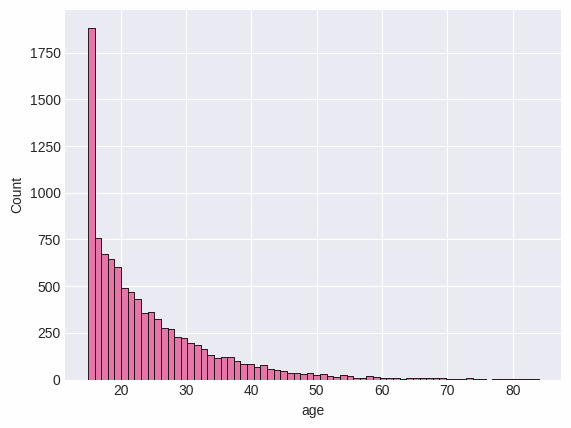

In [1115]:
sns.histplot(df_users["age"])
sns.histplot(df_users["age"])
plt.show()

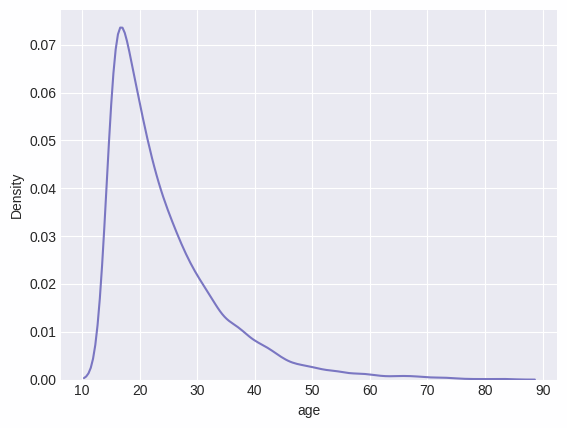

In [1121]:
sns.kdeplot(df_users["age"])
plt.show()

Решение будем принимать на основе теста Колмогорова-Смирнова,
т.е. гипотеза следующая: 
$$
    H_0 = \{ \text{Пусть возраст распределен по закону X}\},
$$
будем пытаться подобрать параметры для такого закона X

In [1242]:
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "gamma", "expon", "weibull_max", "weibull_min", "pareto", "genextreme", "gengamma", "levy", "maxwell"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(sp.stats, dist_name)
        param = dist.fit(data)
        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = sp.stats.kstest(data, dist_name, args=param)
        # print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [1243]:
get_best_distribution(df_users["age"])

Best fitting distribution: genextreme
Best p value: 5.061190826920891e-57
Parameters for the best fit: (-0.49656092164640475, 18.99353302762642, 4.529315925682916)


('genextreme',
 5.061190826920891e-57,
 (-0.49656092164640475, 18.99353302762642, 4.529315925682916))

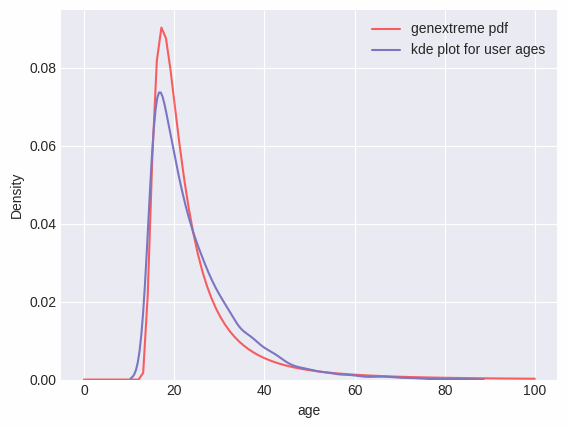

In [1259]:
x = np.linspace(0,
                100, 100)
genextreme_rv = sp.stats.genextreme(-0.49656092164640475, 18.99353302762642, 4.529315925682916)
plt.plot(x, genextreme_rv.pdf(x), "r", alpha=0.6, label="genextreme pdf")
sns.kdeplot(df_users["age"], label="kde plot for user ages")
plt.legend()
plt.show()

Да, $pvalue$ получилось меньше 0.05, следовательно, такую гипотезу нужно отклонить.

Ради интереса, посмотрим, что даст тест Манна-Уитни для такого распределения:

In [1278]:
res = []
p_res = []
for _ in range(3000):
    x = genextreme_rv.rvs(df_users.shape[0])
    x = x[np.where(x < 90)]
    test = sp.stats.mannwhitneyu(df_users["age"], x, alternative="two-sided")
    p_res.append(test.pvalue)
    if test.pvalue > 0.05:
        res.append(1)
    else: 
        res.append(0)
cnt = Counter(res)
print(cnt)
if cnt[1] > cnt[0]:
    print("гипотезу принимаем")
else: 
    print("гипотезу отклоняем")

Counter({0: 2954, 1: 46})
гипотезу отклоняем


Аналогично, отклоняем гипотезу о схожести с распределением `genextrem`.

Да, подобрать распределение не получилось, но мы хотя бы попоробовали.